# some figures related to single-site emulator

In [1]:
import sys, os, glob, pickle, toml, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

def get_mae(d1, d2):
    return np.nanmean( np.abs(d1 - d2) )

def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]


In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# load data

path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

methods1 = ['rf', 'mlp']
methods2 = ['RF', 'MLP']
metprefix = [ ['rf', 'rf_group',  'rf_cluster'], 
             ['mlp', 'mlp_group',  'mlp_cluster']]
types = ['standard', 'group', 'cluster']

cv_est = []

# standard and group are 5-fold
# cluster is 15-fold because of 15 folds
cv_eval = np.nan * np.zeros([2, 2, 2, 3]) # rmse/cc; train/test; rf/mlp; standard/group/cluster
lab = []

for i in range(2):
    for j in range(3):
        lab.append(f'{methods2[i]} {types[j]}')
        
        file = f'{path}/LSE_{methods2[i]}_normKGE_{types[j]}CV_estimates.pkl'
        with open(file, 'rb') as file:
            cv_est.append( pickle.load(file) )
    
        file =  f'{path}/LSE_{methods2[i]}_normKGE_{types[j]}CV_evaluation.npz'
        dtmp = np.load(file)
        cv_eval[0,0,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_rmse_train'])
        cv_eval[0,1,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_rmse_test'])
        cv_eval[1,0,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_cc_train'])
        cv_eval[1,1,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_cc_test'])

print(lab)

['RF standard', 'RF group', 'RF cluster', 'MLP standard', 'MLP group', 'MLP cluster']


# RF/MLP standard/group CV

## scatter plot

In [4]:
dataplot = []
for d in cv_est:
    dinput = np.array([])
    dest = np.array([])
    for i in range(len(d)):
        dinput = np.hstack([dinput, np.squeeze(d[i]['y_test'])])
        dest = np.hstack([dest,  np.squeeze(d[i]['y_test_pred'])])

    dd = np.vstack([dinput, dest]).T
    dataplot.append(dd)

dataplot = np.array(dataplot)

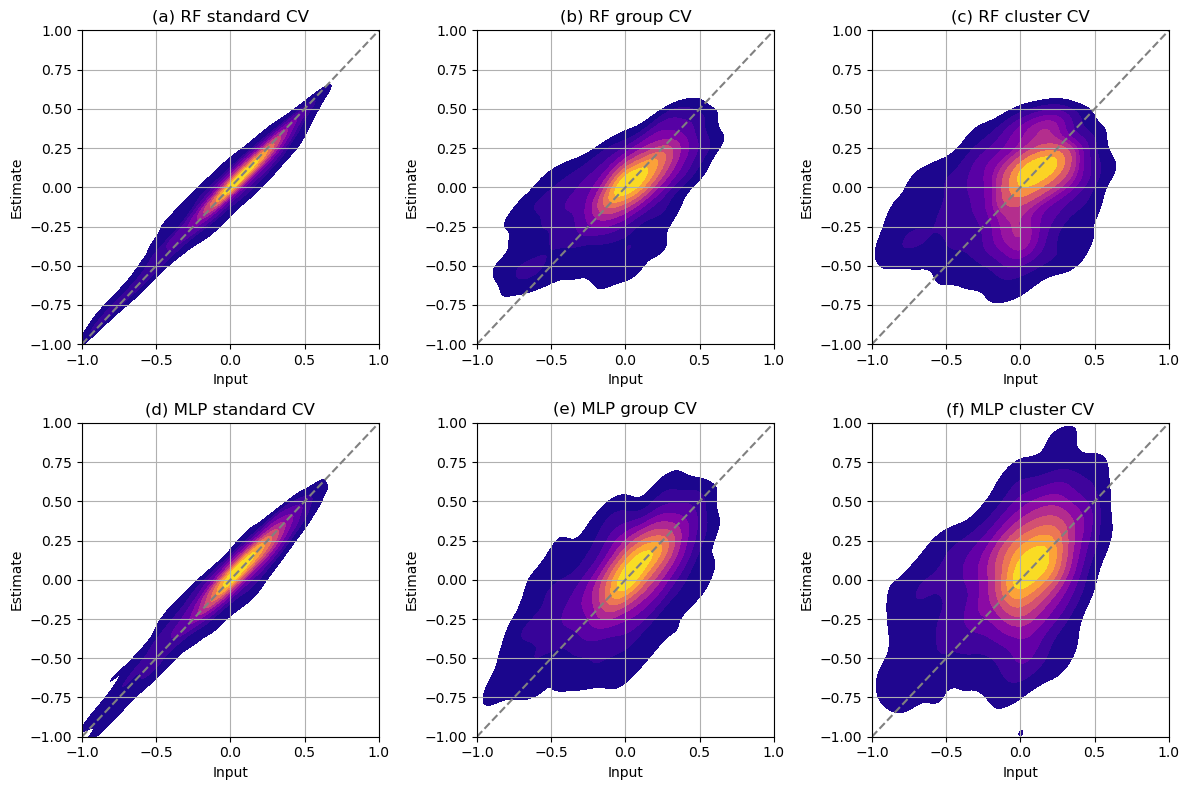

In [5]:
labels = ['(a) RF standard CV', '(b) RF group CV', '(c) RF cluster CV', 
          '(d) MLP standard CV', '(e) MLP group CV', '(f) MLP cluster CV']


step = 100 # no need to plot all points

fig = plt.figure(figsize=(12, 8))

for i in range(6):
    fig.add_subplot(2,3,i+1)
    sns.kdeplot(x=dataplot[i, ::step, 0], y=dataplot[i, ::step, 1], fill=True, cmap='plasma')
    plt.plot([-1,1],[-1,1], '--', color='grey')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    plt.xlabel('Input')
    plt.ylabel('Estimate')
    plt.title(labels[i])
    plt.grid('on')

plt.tight_layout()
plt.savefig('LSE_standard_group_cluster_CV_scatter.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

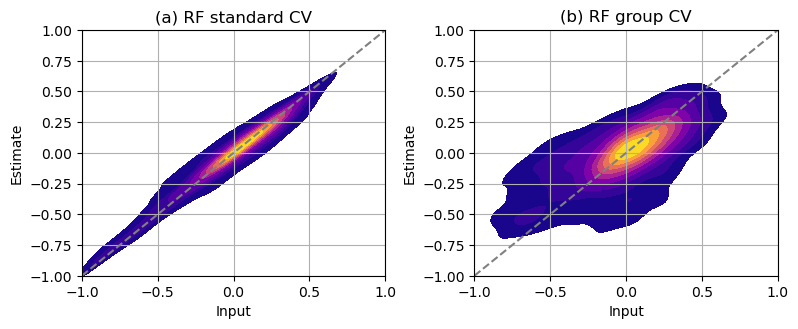

In [9]:
labels = ['(a) RF standard CV', '(b) RF group CV', ]

dataplot2 = dataplot[[0,1],:,:]

step = 100 # no need to plot all points

fig = plt.figure(figsize=(8, 6))

for i in range(2):
    fig.add_subplot(2,2,i+1)
    sns.kdeplot(x=dataplot2[i, ::step, 0], y=dataplot2[i, ::step, 1], fill=True, cmap='plasma')
    plt.plot([-1,1],[-1,1], '--', color='grey')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    plt.xlabel('Input')
    plt.ylabel('Estimate')
    plt.title(labels[i])
    plt.grid('on')

plt.tight_layout()
plt.savefig('LSE_RF_standard_group_CV_scatter.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## bar plot showing accuracy metric

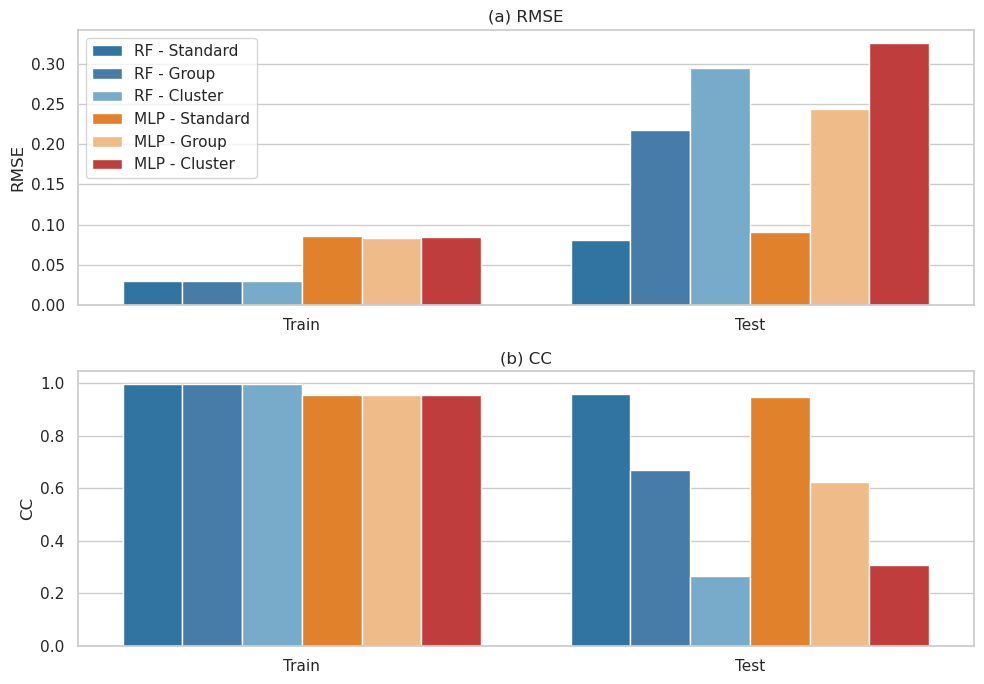

In [218]:


# Define custom colors for RF and MLP with different shades
palette = {
    'RF - Standard': '#1f77b4',      # Blue
    'RF - Group': '#377eb8',         # Slightly different blue
    'RF - Cluster': '#6baed6',       # Another different blue
    'MLP - Standard': '#ff7f0e',     # Orange
    'MLP - Group': '#ffbb78',        # Lighter orange
    'MLP - Cluster': '#d62728'       # Red-ish orange
}

# Labels for the groups and sub-groups
categories = ['Train', 'Test']
models = ['RF', 'MLP']
types = ['Standard', 'Group', 'Cluster']


titles = ['(a) RMSE', '(b) CC']
ylabs = ['RMSE', 'CC']
fig = plt.figure(figsize=(10, 7))

for ii in range(2):
    metplot = cv_eval[ii] 
    fig.add_subplot(2,1,ii+1)

    # Prepare the data for seaborn
    data = []
    for i, category in enumerate(categories):
        for j, model in enumerate(models):
            for k, type_ in enumerate(types):
                data.append([category, model, type_, metplot[i, j, k]])
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Category', 'Model', 'Type', 'RMSE'])
    
    # Combine Model and Type into a single column for hue
    df['Model_Type'] = df['Model'] + ' - ' + df['Type']
    
    
    # Create the plot using seaborn
    sns.set(style="whitegrid")

    ax = sns.barplot(data=df, x="Category", y="RMSE", hue="Model_Type", palette=palette)
    
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel(ylabs[ii])
    ax.set_title("Train/Test RMSE for RF and MLP with Standard, Group, and Cluster Methods")

    # Adjust the legend
    if ii==0:
        plt.legend(loc='upper left')
    else:
        ax.legend().set_visible(False)
        
    plt.title(titles[ii])

plt.tight_layout()
# Show the plot
plt.savefig('LSE_allmethod_traintest_bar.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# The spatial distribution of metrics
This is the most meaningful for group/cluster CV, but can also be calculated for standard CV

In [5]:
file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out/basin_id_forinput.gz'
df_basinid = pd.read_csv(file, compression='gzip')

In [6]:
met = np.nan * np.zeros([len(df_info), 3, len(cv_est)]) # rmse/cc/mae; ['RF standard', 'RF group', 'RF cluster', 'MLP standard', 'MLP group', 'MLP cluster']

for cc in range(len(cv_est)):
    cvi = cv_est[cc]
    
    dataplot = []
    dinput = np.array([])
    dest = np.array([])
    dindex = np.array([])
    for i in range(len(cvi)):
        dinput = np.hstack([dinput, np.squeeze(cvi[i]['y_test'])])
        dest = np.hstack([dest,  np.squeeze(cvi[i]['y_test_pred'])])
        dindex = np.hstack([dindex,  np.squeeze(cvi[i]['test_index'])])
    
    dd = np.vstack([dindex, dinput, dest]).T
    ind = np.argsort(dindex)
    dd = dd[ind, :]
    if len(dd) != (dd[-1,0]-dd[0,0]+1):
        print('Warning! error')
    
    
    for i in range(len(df_info)):
        indi = np.where(df_basinid['basin_id'].values==i)[0]
        ddi = dd[indi, :]
        met[i, 0, cc] = get_rmse(ddi[:,1], ddi[:,2])
        met[i, 1, cc] = get_cc(ddi[:,1], ddi[:,2])
        met[i, 2, cc] = get_mae(ddi[:,1], ddi[:,2])

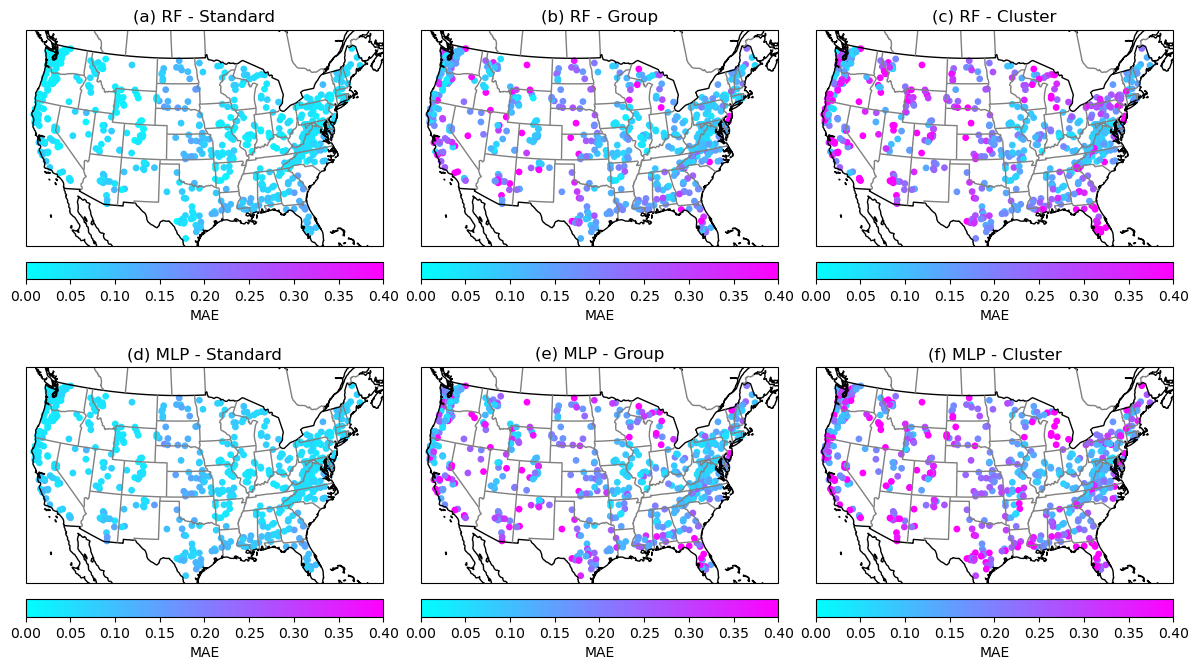

In [8]:
# plot rmse

lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values

title = ["(a) RF - Standard", "(b) RF - Group", "(c) RF - Cluster", 
         "(d) MLP - Standard", "(e) MLP - Group", "(f) MLP - Cluster", ]
cmaps = ['cool', 'cool', 'cool', 
         'cool', 'cool', 'cool', 
         ]
lims = [ [0, 0.4], [0, 0.4], [0,0.4], 
         [0, 0.4], [0, 0.4], [0, 0.4],
       ]


fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, met[:, 2, i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='MAE', pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.savefig('LSE_RF_GPR_CV_MAE_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

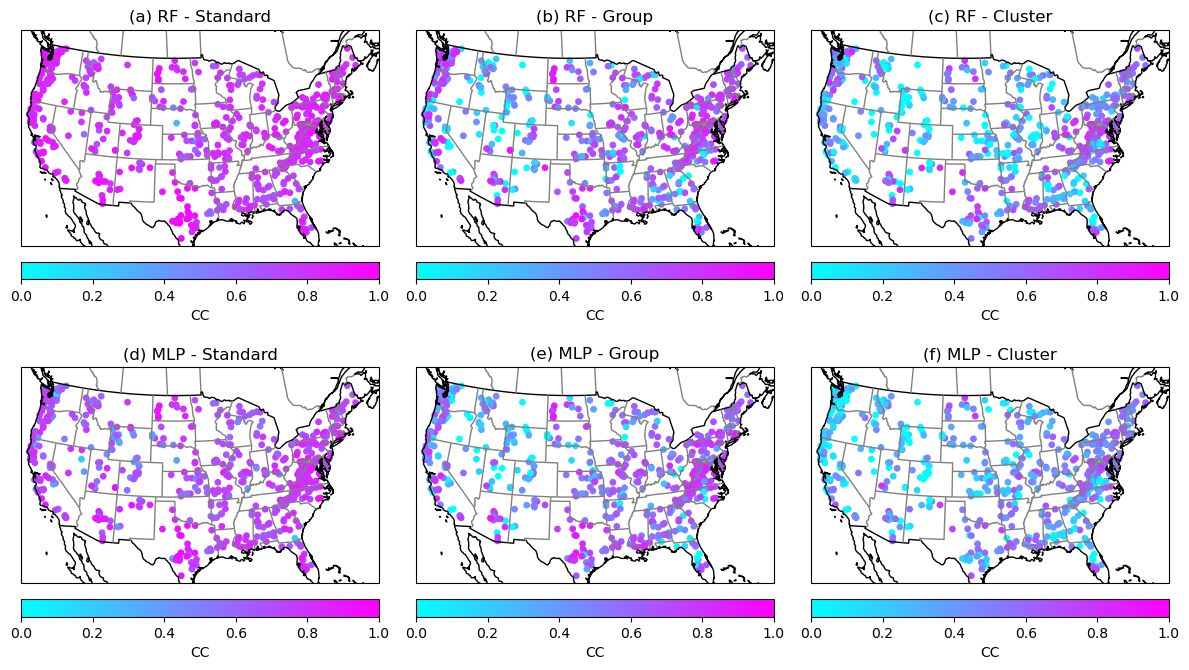

In [9]:
# plot rmse

title = ["(a) RF - Standard", "(b) RF - Group", "(c) RF - Cluster", 
         "(d) MLP - Standard", "(e) MLP - Group", "(f) MLP - Cluster", ]
cmaps = ['cool', 'cool', 'cool', 
         'cool', 'cool', 'cool', 
         ]


fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, met[:, 1, i], cmap=cmaps[i], vmin=0, vmax=1, transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='CC', pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.savefig('LSE_RF_GPR_CV_CC_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()